In [22]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

custom_palette = {
    0: 'red',
    0.1: 'lightblue',
    0.5: 'lightblue',
    1: 'dodgerblue',
    2: 'royalblue',
    4: 'blue',
    16: 'navy',
    32: 'darkblue',
    64: 'midnightblue',
    'DISCREPANCY': sns.color_palette('Set2')[0],  # Default Seaborn palette color for 'DISCREPANCY'
    'ENTROPY': sns.color_palette('Set2')[1],  # Default Seaborn palette color for 'ENTROPY'
    'NegCE': sns.color_palette('Set2')[2],  # Default Seaborn palette color for 'NegCE'
    'DBAT': sns.color_palette('Set2')[3]  # Default Seaborn palette color for 'DBAT'
}

N_SAMPLES = 1000
tag = 'cam_exp'
df_path = f'dfs/{tag}.pk'

try:
    df = pd.read_pickle(df_path)
except:
    df = pd.DataFrame()

r_dfs = []
runs = wandb.Api().runs('mila-projects/domainbed', filters={'tags': tag, 'state': 'finished'})

for r in runs:
    config = r.config
    run_id = config['run_id']
    tags_str = '/'.join(r.tags)
    config['tags'] = tags_str
    if 'run_id' in df.columns and df.run_id.str.contains(run_id).any():
        continue
    r_df = r.history(samples=N_SAMPLES)
    assert r_df.step.max() == 5000
    for k, v in config.items():
        if isinstance(v, list) and len(v) > 1:
            raise Exception(k, v)
        elif isinstance(v, list):
            v = v[0]
        r_df[k] = v
    df = pd.concat([df, r_df], ignore_index=True)

df.to_pickle(df_path)
df = pd.read_pickle(df_path)

## Backfill values
df.loc[df['grad_penalty'].isna(), 'grad_penalty'] = 0.0
df['mlp_width'] = df['hparam_mlp_width']
df['mlp_depth'] = df['hparam_mlp_depth']
df['train_acc'] = df['train_in_acc']
df['val_acc'] = df['env1_out_acc']
df['wgan_grad_loss'] = df['grad_penalty_loss']
df.loc[df['algorithm'] == 'ERM', 'dann_disc_loss'] = ''
df['alg_name'] = df['algorithm'] + '_' + df['dann_disc_loss']
df.rename(columns={'testenv_in_acc': 'test_acc'}, inplace=True)
df = df.query('algorithm != "ERM"')

In [44]:
df.query('dann_disc_loss=="DISCREPANCY" and step==4000').groupby(['dann_disc_loss', 'grad_penalty', 'disc_params', 'dann_lambda'], as_index=False)[['test_acc']].agg(['mean', 'std']).reset_index().sort_values((      'test_acc', 'mean'), ascending=False).head(30)

dann_disc_loss grad_penalty disc_params dann_lambda  test_acc          
                                                            mean       std
47    DISCREPANCY          1.0    263428.0         0.1  0.825407       NaN
62    DISCREPANCY          1.0   1052164.0         0.1  0.825260       NaN
9     DISCREPANCY          0.0    263428.0         0.1  0.819676       NaN
68    DISCREPANCY          2.0    460804.0         0.1  0.813408  0.062757
69    DISCREPANCY          2.0    460804.0         1.0  0.809608  0.076069
59    DISCREPANCY          1.0    526852.0         0.1  0.807081       NaN
26    DISCREPANCY          0.0    526852.0         0.1  0.797807       NaN
53    DISCREPANCY          1.0    460804.0         0.1  0.792039  0.073585
71    DISCREPANCY          4.0    460804.0         0.1  0.791209  0.059421
35    DISCREPANCY          0.5    460804.0         0.1  0.787652  0.059400
0     DISCREPANCY          0.0     65860.0         0.1  0.787652       NaN
56    DISCREPANCY          1.0    526596.0         0.1  0.771413       NaN
15    DISCREPANCY          0.0    460804.0         0.0  0.768620  0.074681
16    DISCREPANCY          0.0    460804.0         0.1  0.767983  0.056974
38    DISCREPANCY          1.0     65860.0         0.1  0.744107       NaN
13    DISCREPANCY          0.0    395012.0         1.0  0.742696       NaN
29    DISCREPANCY          0.0   1052164.0         0.1  0.736685       NaN
41    DISCREPANCY          1.0     74180.0         0.1  0.729161       NaN
32    DISCREPANCY          0.0   1577476.0         0.1  0.718829       NaN
3     DISCREPANCY          0.0     74180.0         0.1  0.711687       NaN
70    DISCREPANCY          2.0    460804.0         2.0  0.708108  0.046649
8     DISCREPANCY          0.0     82500.0         2.0  0.706220       NaN
10    DISCREPANCY          0.0    263428.0         1.0  0.705602       NaN
23    DISCREPANCY          0.0    526596.0         0.1  0.702443       NaN
65    DISCREPANCY          1.0   1577476.0         0.1  0.699033       NaN
45    DISCREPANCY          1.0     82500.0         1.0  0.698930       NaN
7     DISCREPANCY          0.0     82500.0         1.0  0.692508       NaN
50    DISCREPANCY          1.0    395012.0         0.1  0.690891       NaN
12    DISCREPANCY          0.0    395012.0         0.1  0.688496       NaN
52    DISCREPANCY          1.0    395012.0         2.0  0.676033       NaN

In [23]:
df['run_id'].unique().shape

(154,)

In [75]:
def plot_facet_grid(df, hue, y, row=None, col=None, x='step', melt_metrics=None, palette=custom_palette, title=None, **grid_kwargs):
    if melt_metrics is not None:
        id_vars = ['step', 'dann_disc_loss', 'dann_lambda']
        if hue not in id_vars:
            id_vars.append(hue)
        df = df.melt(id_vars=id_vars, var_name='metric', value_name='value')
        df = df[df['metric'].isin(melt_metrics)]
        df['metric'] = pd.Categorical(df['metric'], melt_metrics)
        df = df.sort_values('metric')
    g = sns.FacetGrid(df, col=col, row=row, sharey=False, **grid_kwargs)
    g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, palette=palette, legend='full')
    prefix = ''
    if col == 'dann_disc_loss':
        prefix = 'loss'
    elif col == 'dann_lambda':
        prefix = 'λ'
    g.set_titles(size=10, col_template=prefix + ":{col_name}", row_template="{row_name}")
    g.add_legend(title=f'{hue}')
    if title:
        g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
        g.fig.suptitle(title)
    return g

In [63]:
base_metrics = ['train_acc', 'val_acc', 'test_acc', 'disc_acc', 'disc_loss', 'gen_disc_loss', 'wgan_grad_loss', 'classifier_loss']
add_metrics = [
    'disc_acc_d0',
        'disc_acc_d1',
        'disc_acc_d2',
        'disc_n_preds_d0',
        'disc_n_preds_d1',
        'disc_n_preds_d2',
        'disc_prob_mean_d0',
        'disc_prob_mean_d1',
        'disc_prob_mean_d2',
        'env0_out_acc',
        'env1_out_acc',
        'env2_out_acc',
        'env3_out_acc',
        'env4_out_acc'
 ]

In [56]:
sorted(df.filter(regex=("prob_mean|disc_acc_|disc_n_preds|env._out")).columns.to_list())

['disc_acc_d0',
 'disc_acc_d1',
 'disc_acc_d2',
 'disc_n_preds_d0',
 'disc_n_preds_d1',
 'disc_n_preds_d2',
 'disc_n_preds_d3',
 'disc_prob_mean_d0',
 'disc_prob_mean_d1',
 'disc_prob_mean_d2',
 'disc_prob_mean_d3',
 'env0_out_acc',
 'env1_out_acc',
 'env2_out_acc',
 'env3_out_acc',
 'env4_out_acc']

In [58]:
df['disc_n_preds_d3'].unique()

array([6.200e+01, 6.350e+00, 0.000e+00, 8.500e+01, 2.860e+01, 4.500e+00,
       3.730e+00, 2.410e+01, 2.156e+01, 3.470e+00, 2.057e+01, 6.340e+00,
       2.858e+01, 4.510e+00, 2.413e+01, 3.720e+00, 2.162e+01, 3.480e+00,
       2.058e+01, 6.330e+00, 4.490e+00, 2.412e+01, 2.161e+01, 6.440e+00,
       9.600e+01, 1.034e+01, 2.919e+01, 4.550e+00, 2.439e+01, 3.165e+01,
       3.780e+00, 2.186e+01, 3.490e+00, 2.078e+01, 6.390e+00, 2.891e+01,
       4.530e+00, 3.740e+00, 2.422e+01, 3.500e+00, 2.069e+01, 2.862e+01,
       2.172e+01, 2.415e+01, 2.059e+01, 3.460e+00, 6.500e+01, 3.000e+00,
       2.000e-02, 4.000e+00, 1.500e-01, 2.207e+01, 6.800e+01, 3.386e+01,
       9.700e-01, 9.400e+00, 2.888e+01, 2.900e+00, 1.400e-01, 2.183e+01,
       2.954e+01, 8.000e-02, 1.035e+01, 3.167e+01, 2.243e+01, 9.000e-02,
       9.390e+00, 2.886e+01, 1.200e-01, 2.199e+01, 2.518e+01, 1.033e+01,
       3.164e+01, 1.100e-01, 2.235e+01, 1.950e+01, 2.881e+01, 9.380e+00,
       2.880e+00, 2.184e+01, 1.878e+01, 2.473e+01, 

### Baseline Results

In [50]:
baseline_df = df[df['tags'].str.contains('cam_baseline')].query('step > 0')
baseline_df_final = baseline_df.query('step==5000')
baseline_df_final.groupby(['dann_lambda', 'dann_disc_loss'])[['test_acc', 'val_acc', 'train_acc', 'disc_loss', 'wgan_grad_loss']].agg(['mean', 'std']).style.format_index(precision=2).format(precision=2)

<Axes: xlabel='dann_lambda', ylabel='test_acc'>

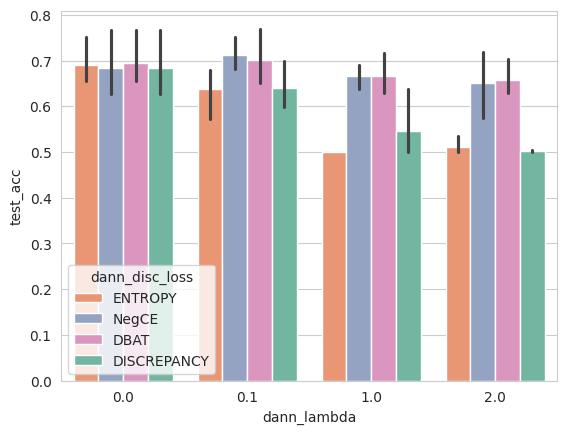

In [29]:
sns.barplot(baseline_df_final, x='dann_lambda', y='test_acc', hue='dann_disc_loss', palette=custom_palette)

In [ ]:
plot_facet_grid(baseline_df, hue='dann_lambda', y='value', row='metric', col='dann_disc_loss', melt_metrics=base_metrics)

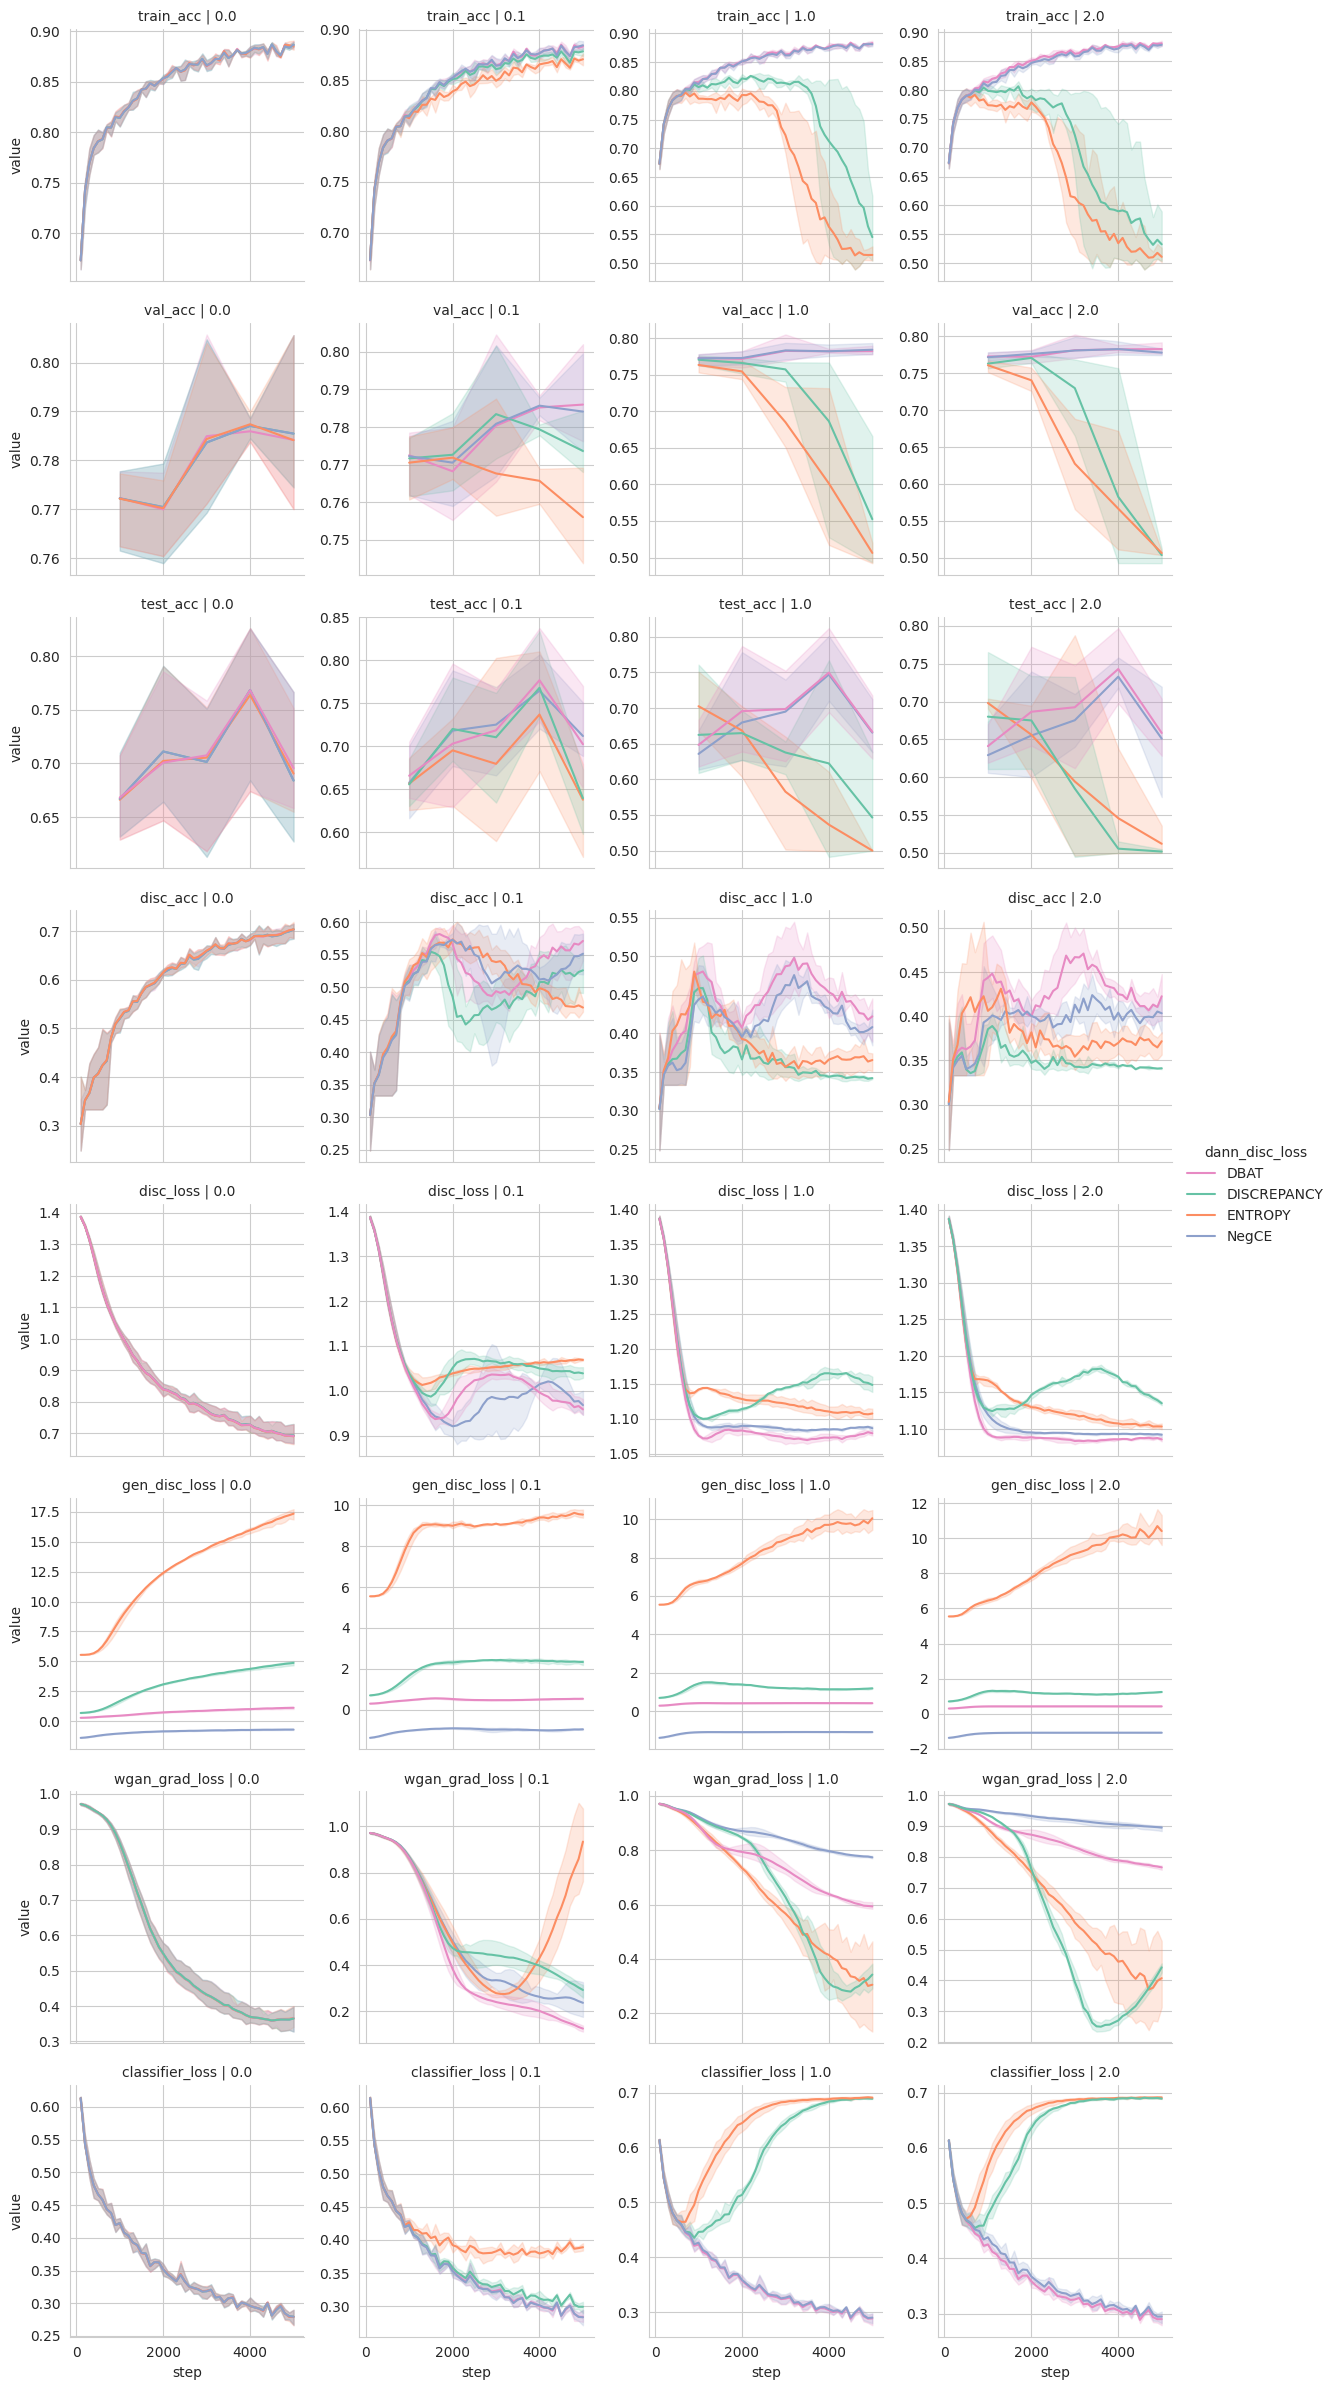

In [48]:
plot_facet_grid(baseline_df, hue='dann_disc_loss', y='value', row='metric', col='dann_lambda', melt_metrics=base_metrics)

### Probing different lambda for discrepancy loss

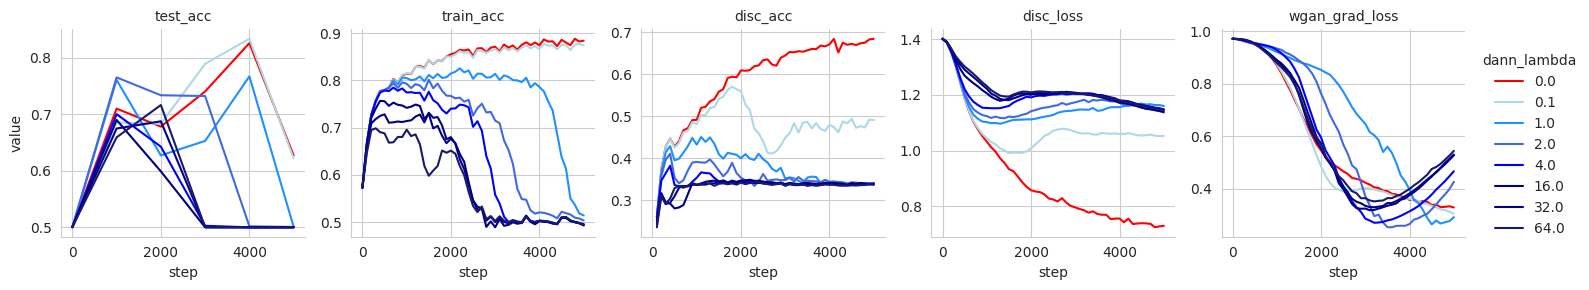

In [66]:
lambda_probe_df = df[df['tags'].str.contains('cam_lambda_probe')]
m = ['test_acc', 'train_acc', 'disc_acc', 'disc_loss', 'wgan_grad_loss']
plot_facet_grid(lambda_probe_df, hue='dann_lambda', y='value', col='metric', melt_metrics=m)

### Discrepancy vs Entropy Loss

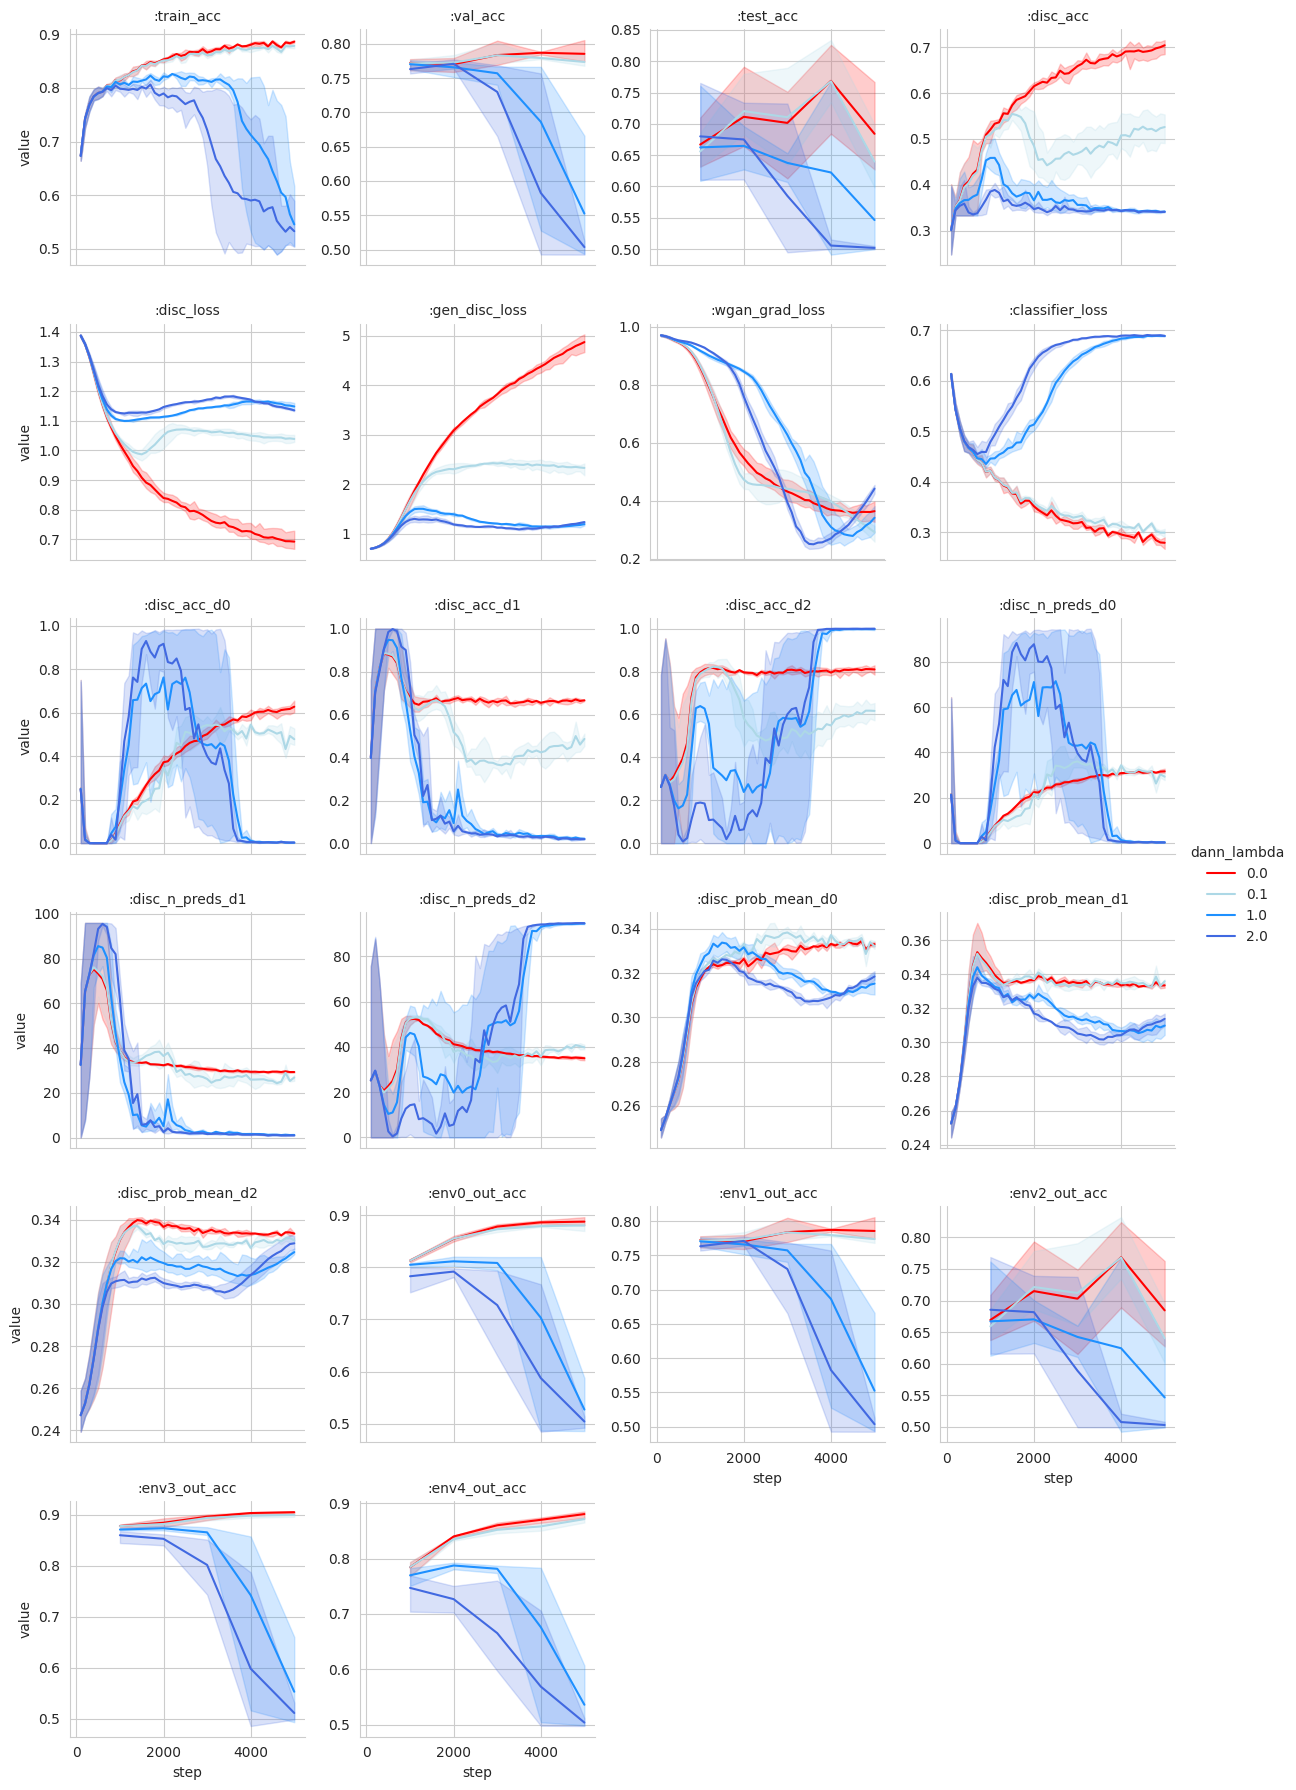

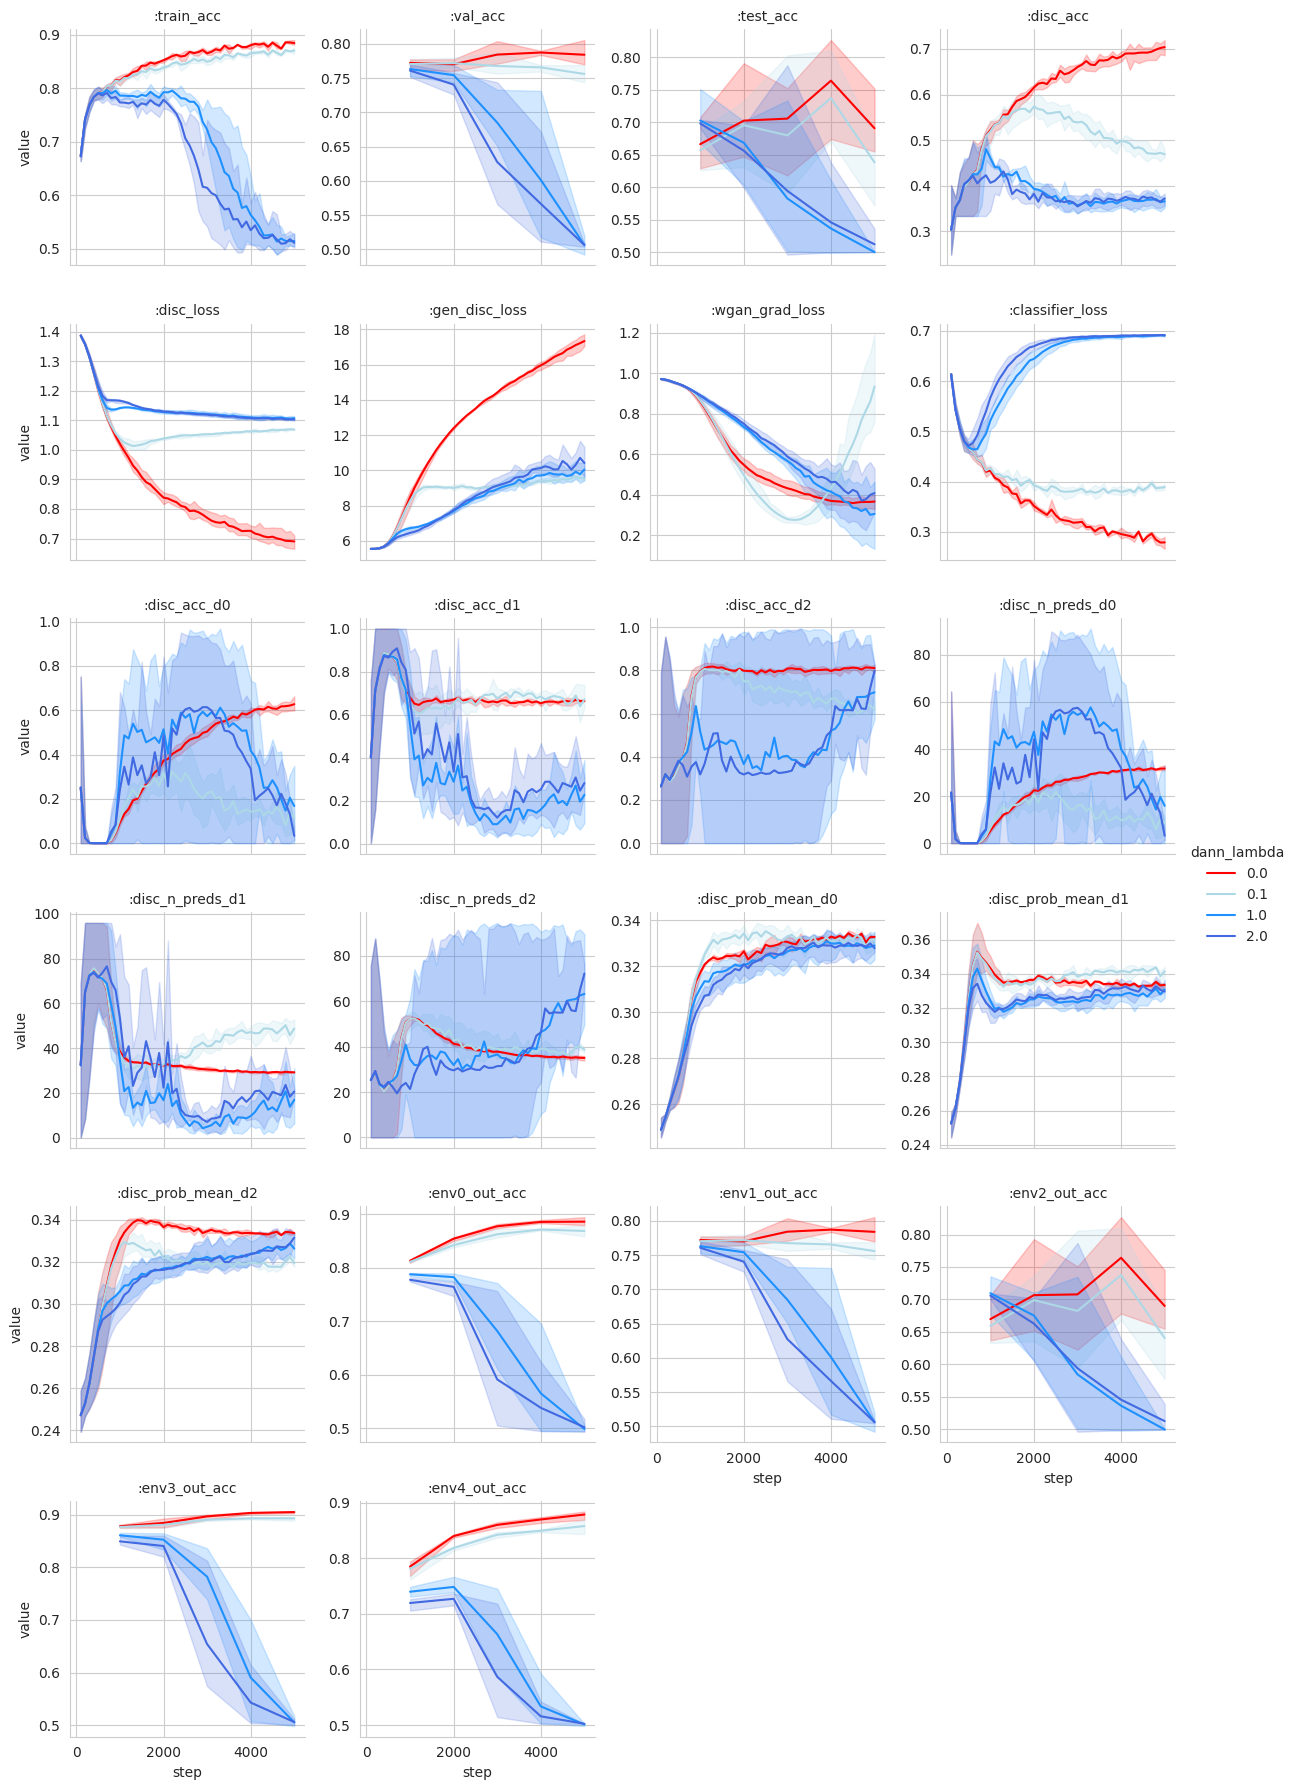

In [73]:
disc_ent_df = baseline_df[baseline_df['dann_disc_loss'].isin(['DISCREPANCY', 'ENTROPY'])]
for loss in ['DISCREPANCY', 'ENTROPY']:
    plot_facet_grid(disc_ent_df.query(f'dann_disc_loss=="{loss}"'), hue='dann_lambda', y='value', col='metric', melt_metrics=base_metrics + add_metrics, col_wrap=4)

### Adding WGAN-GP

In [70]:
grad_pen_df = df[df['tags'].str.contains('cam_gp')]
grad_pen_df.query('step==5000').groupby(['dann_disc_loss', 'grad_penalty', 'dann_lambda'])[['test_acc', 'train_acc']].agg(['mean', 'std']).style.format_index(precision=2).format(precision=2)

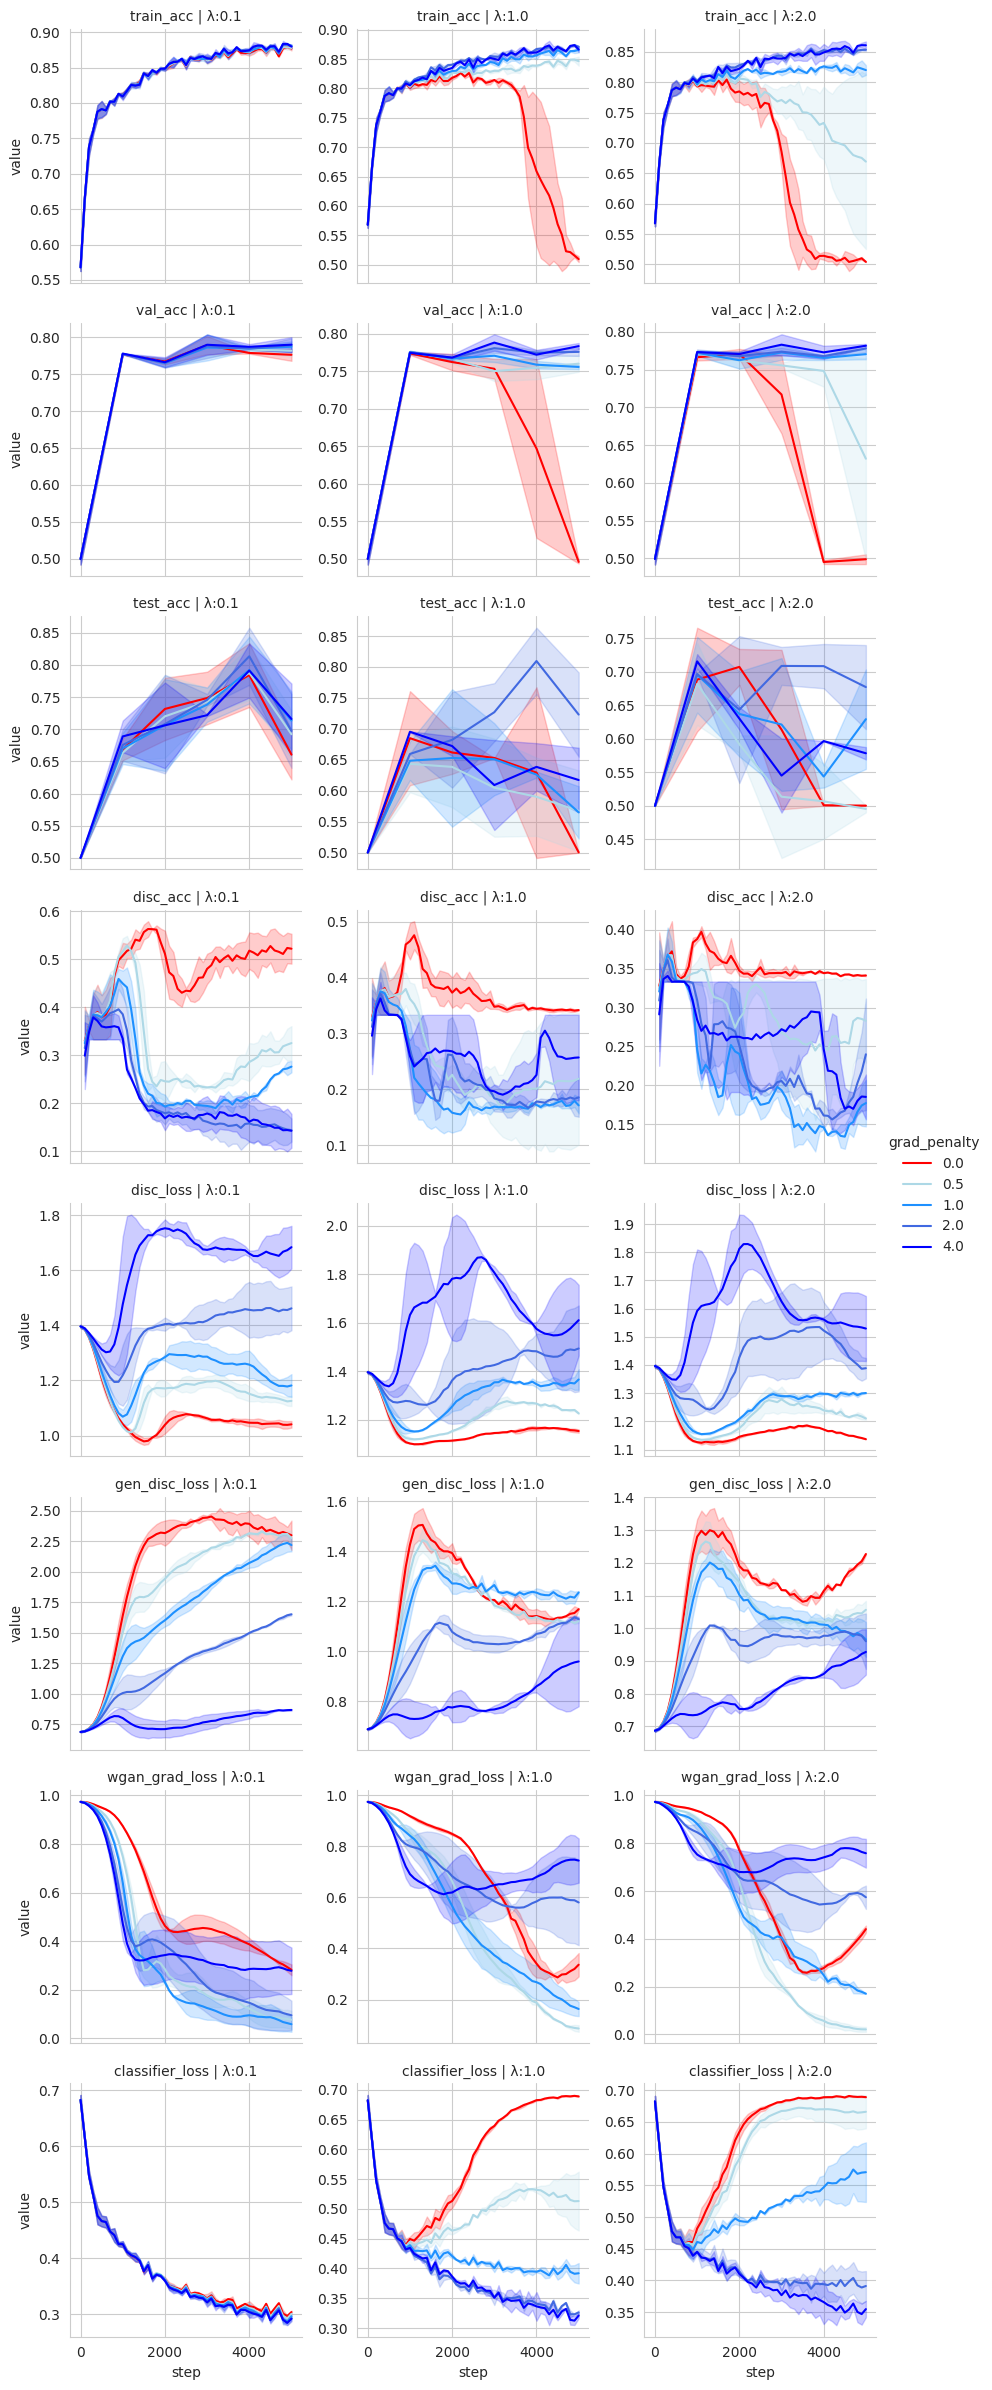

In [77]:
plot_facet_grid(
    grad_pen_df.query('dann_disc_loss=="DISCREPANCY"'), 
    hue='grad_penalty', 
    y='value', 
    row='metric', 
    col='dann_lambda', 
    melt_metrics=base_metrics, 
    )

### Scaling discriminator architecture

In [79]:
arch_df = df[df['tags'].str.contains('cam_arch')]
arch_df.query('step==4000').groupby(['mlp_depth', 'mlp_width', 'grad_penalty', 'dann_lambda'])[['test_acc', 'train_acc']].mean().reset_index().sort_values('test_acc', ascending=False).head(10).reset_index(drop=True).style.format(precision=2)

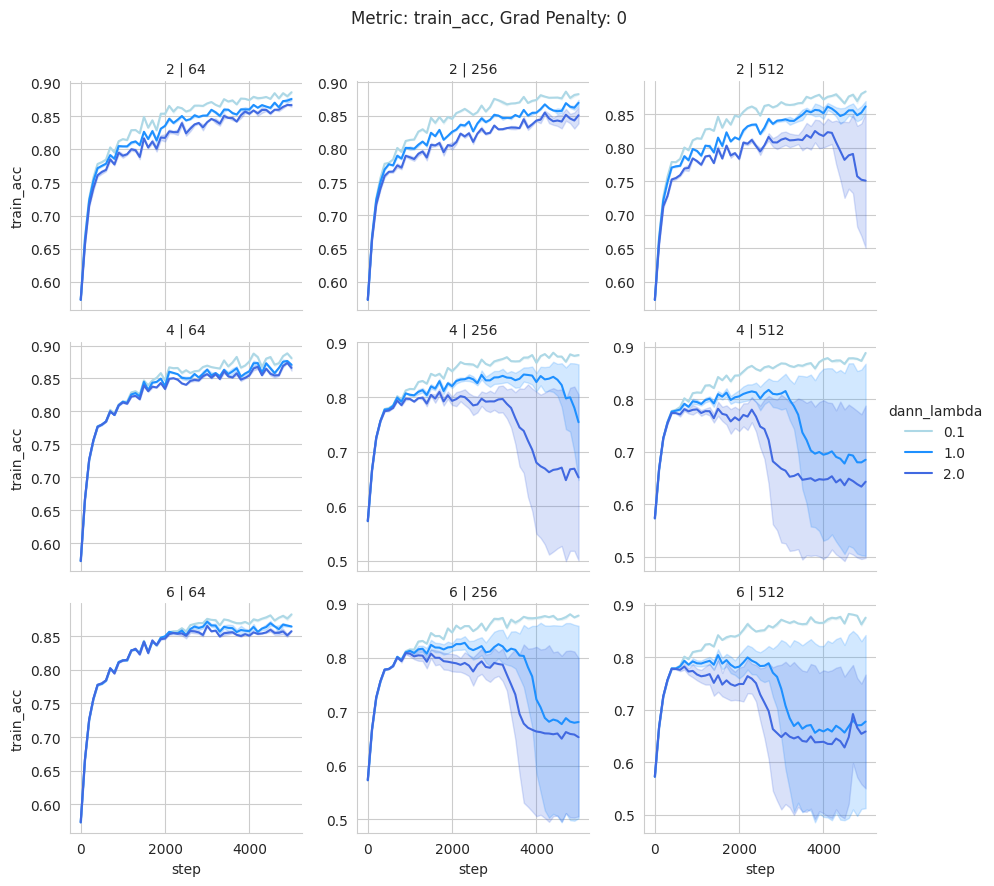

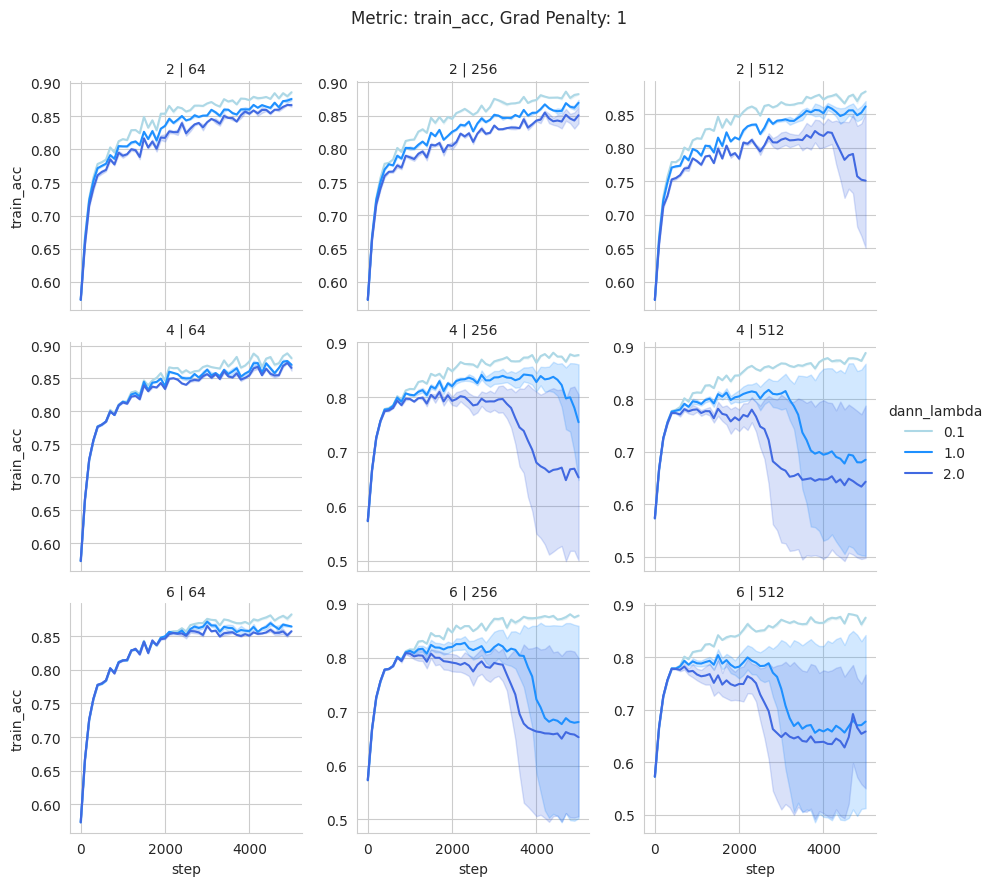

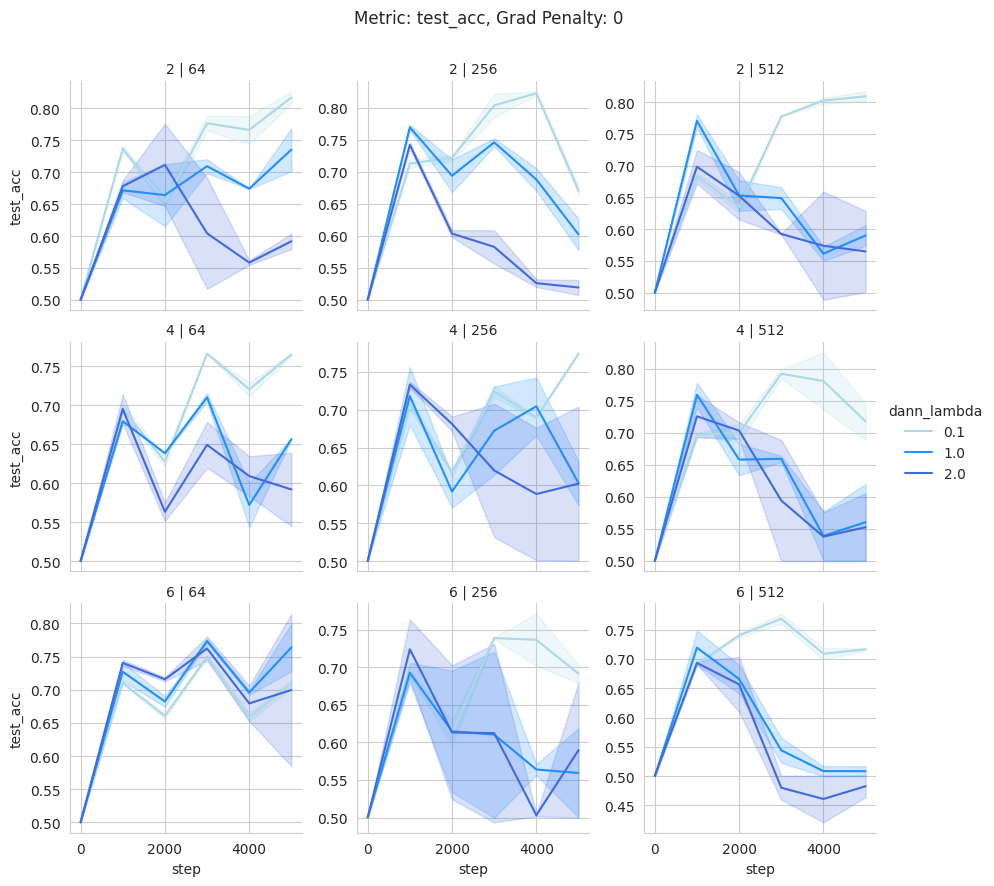

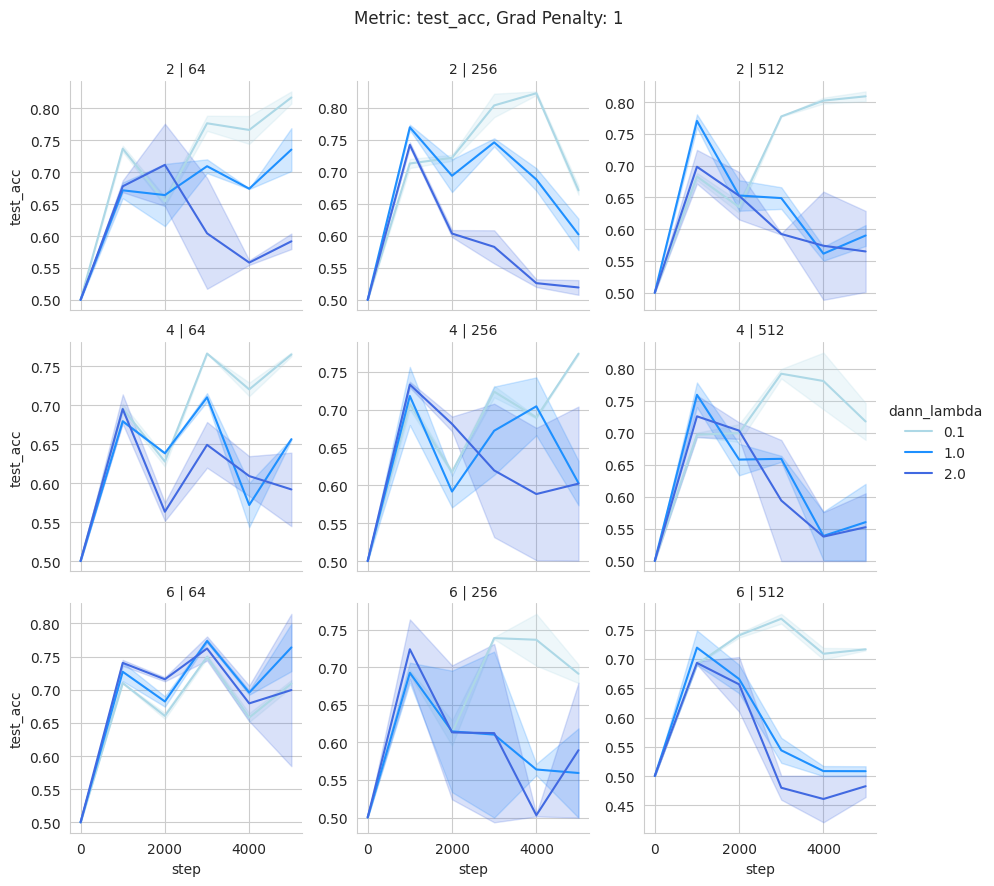

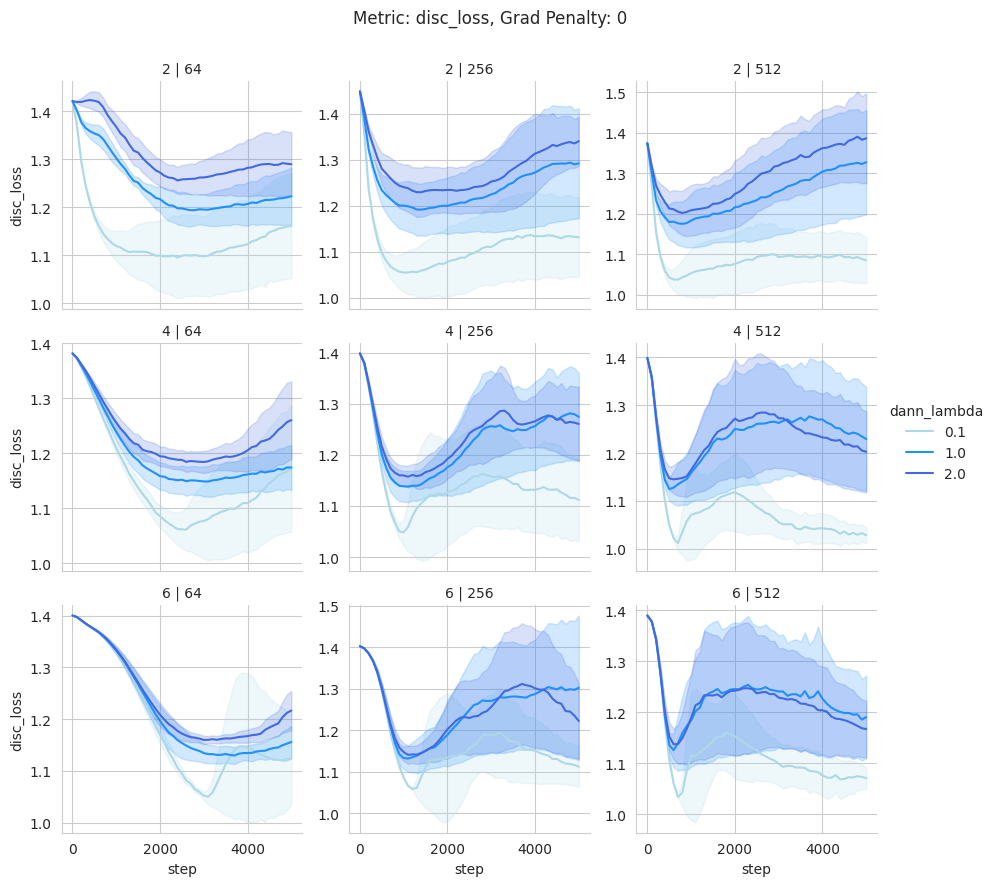

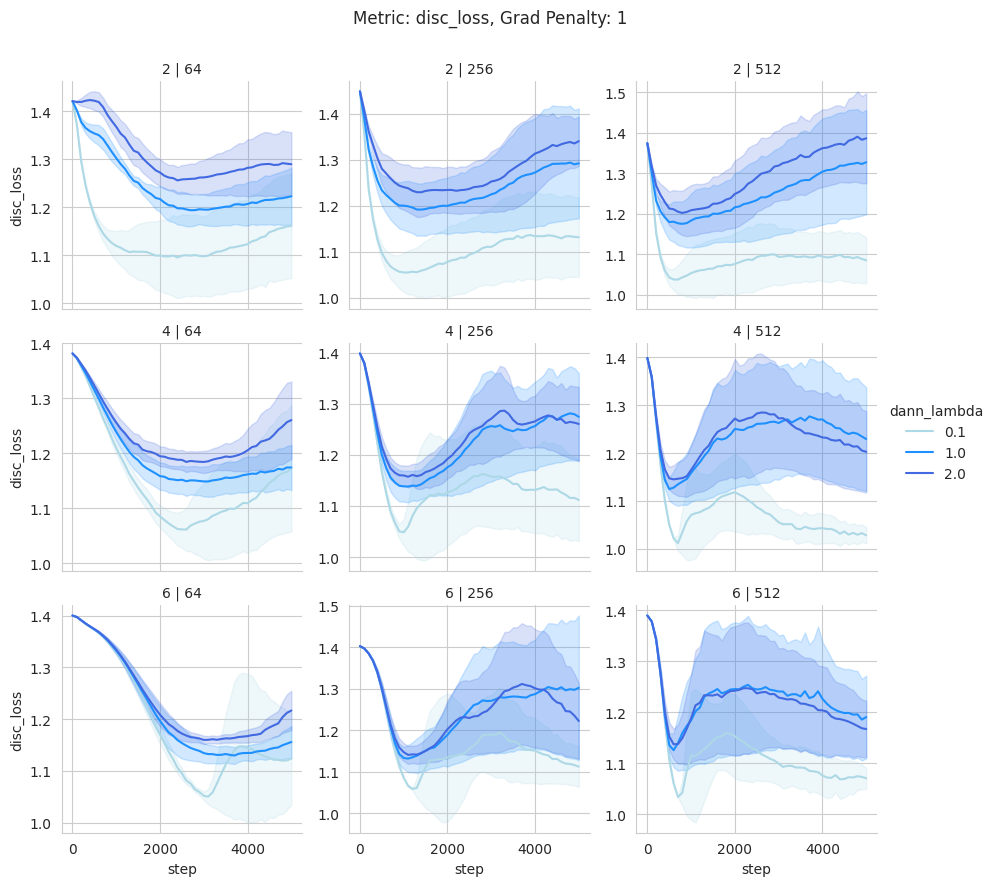

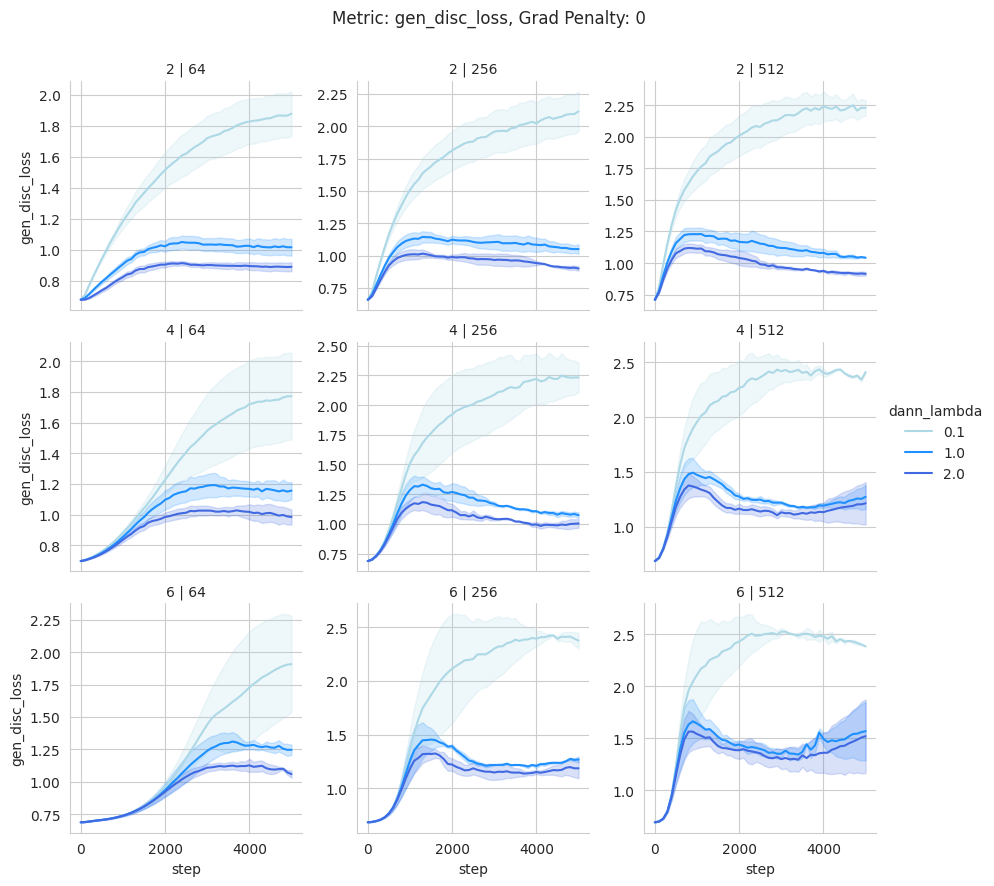

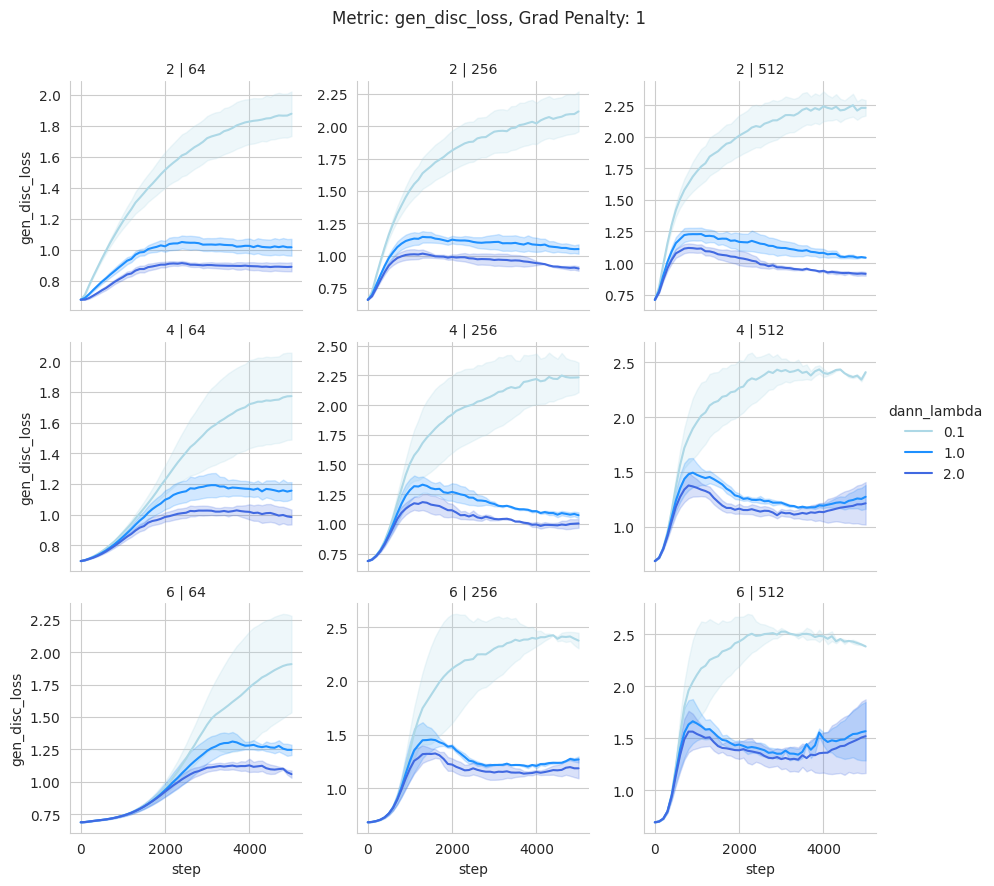

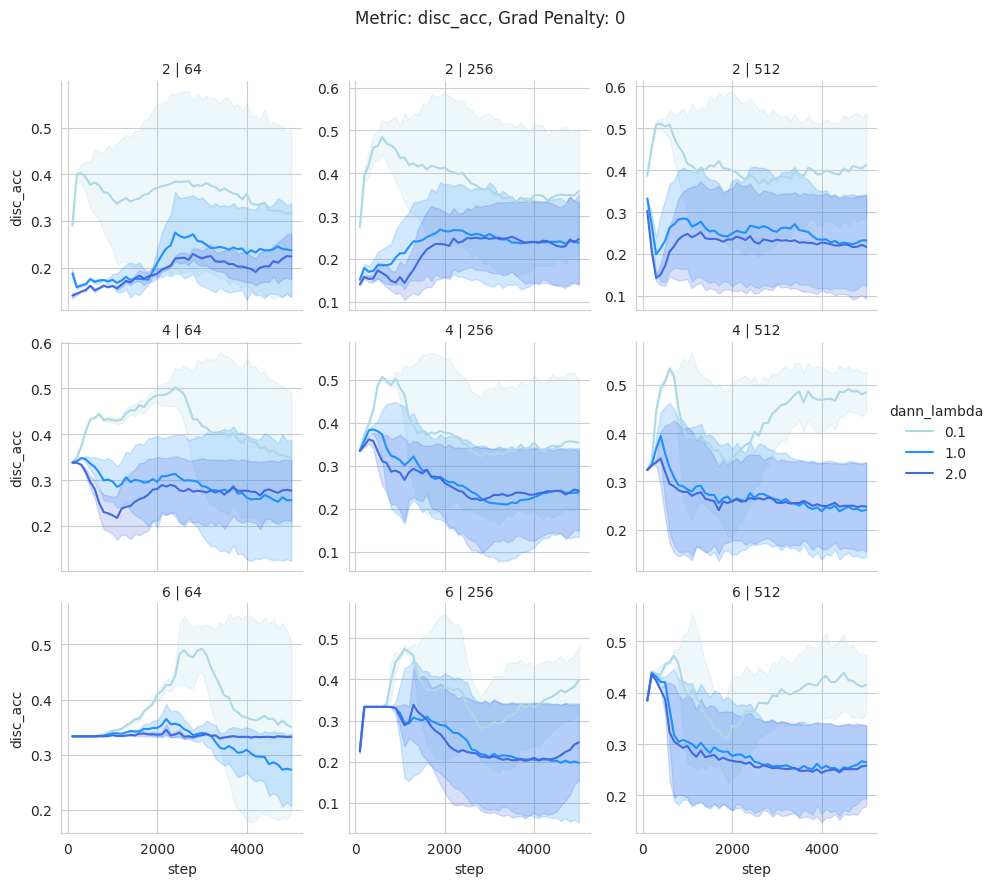

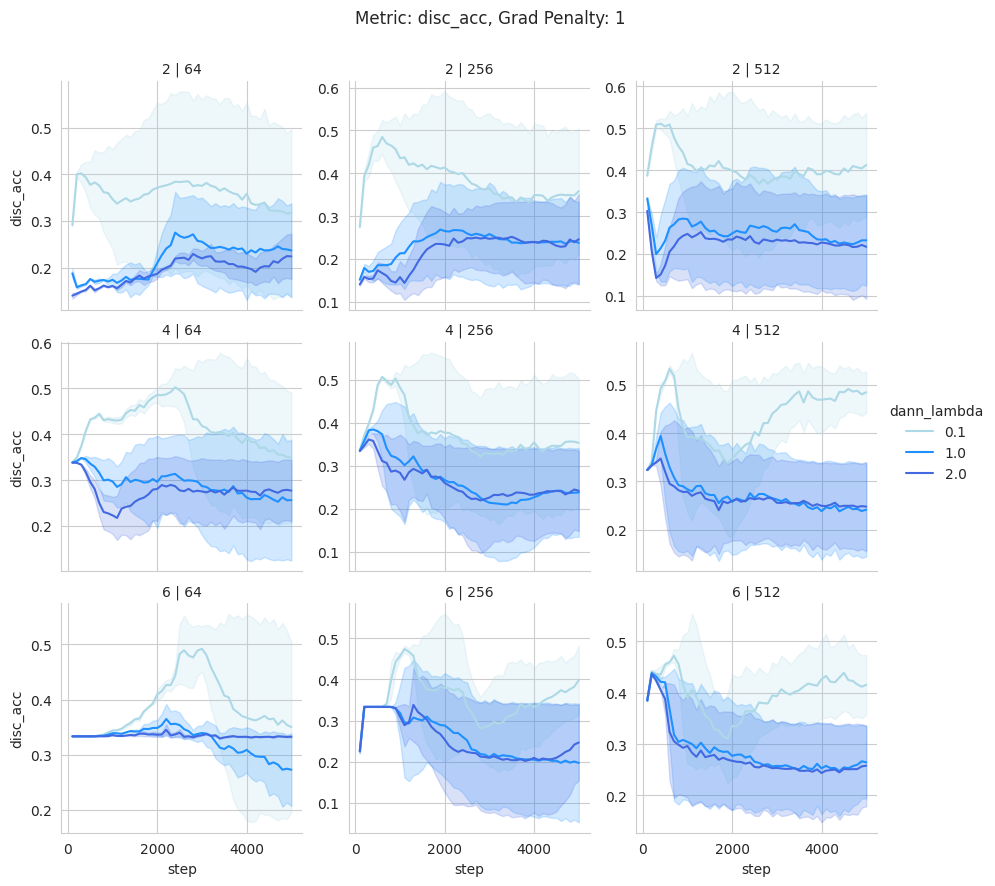

In [12]:
for metric in ['train_acc', 'test_acc', 'disc_loss', 'gen_disc_loss', 'disc_acc']:
    for pen in [0, 1]:
        g = plot_facet_grid(arch_df, hue='dann_lambda', y=metric, row='mlp_depth', col='mlp_width', grid_kwargs={})
        g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
        g.fig.suptitle(f'Metric: {metric}, Grad Penalty: {pen}')
        plt.show()

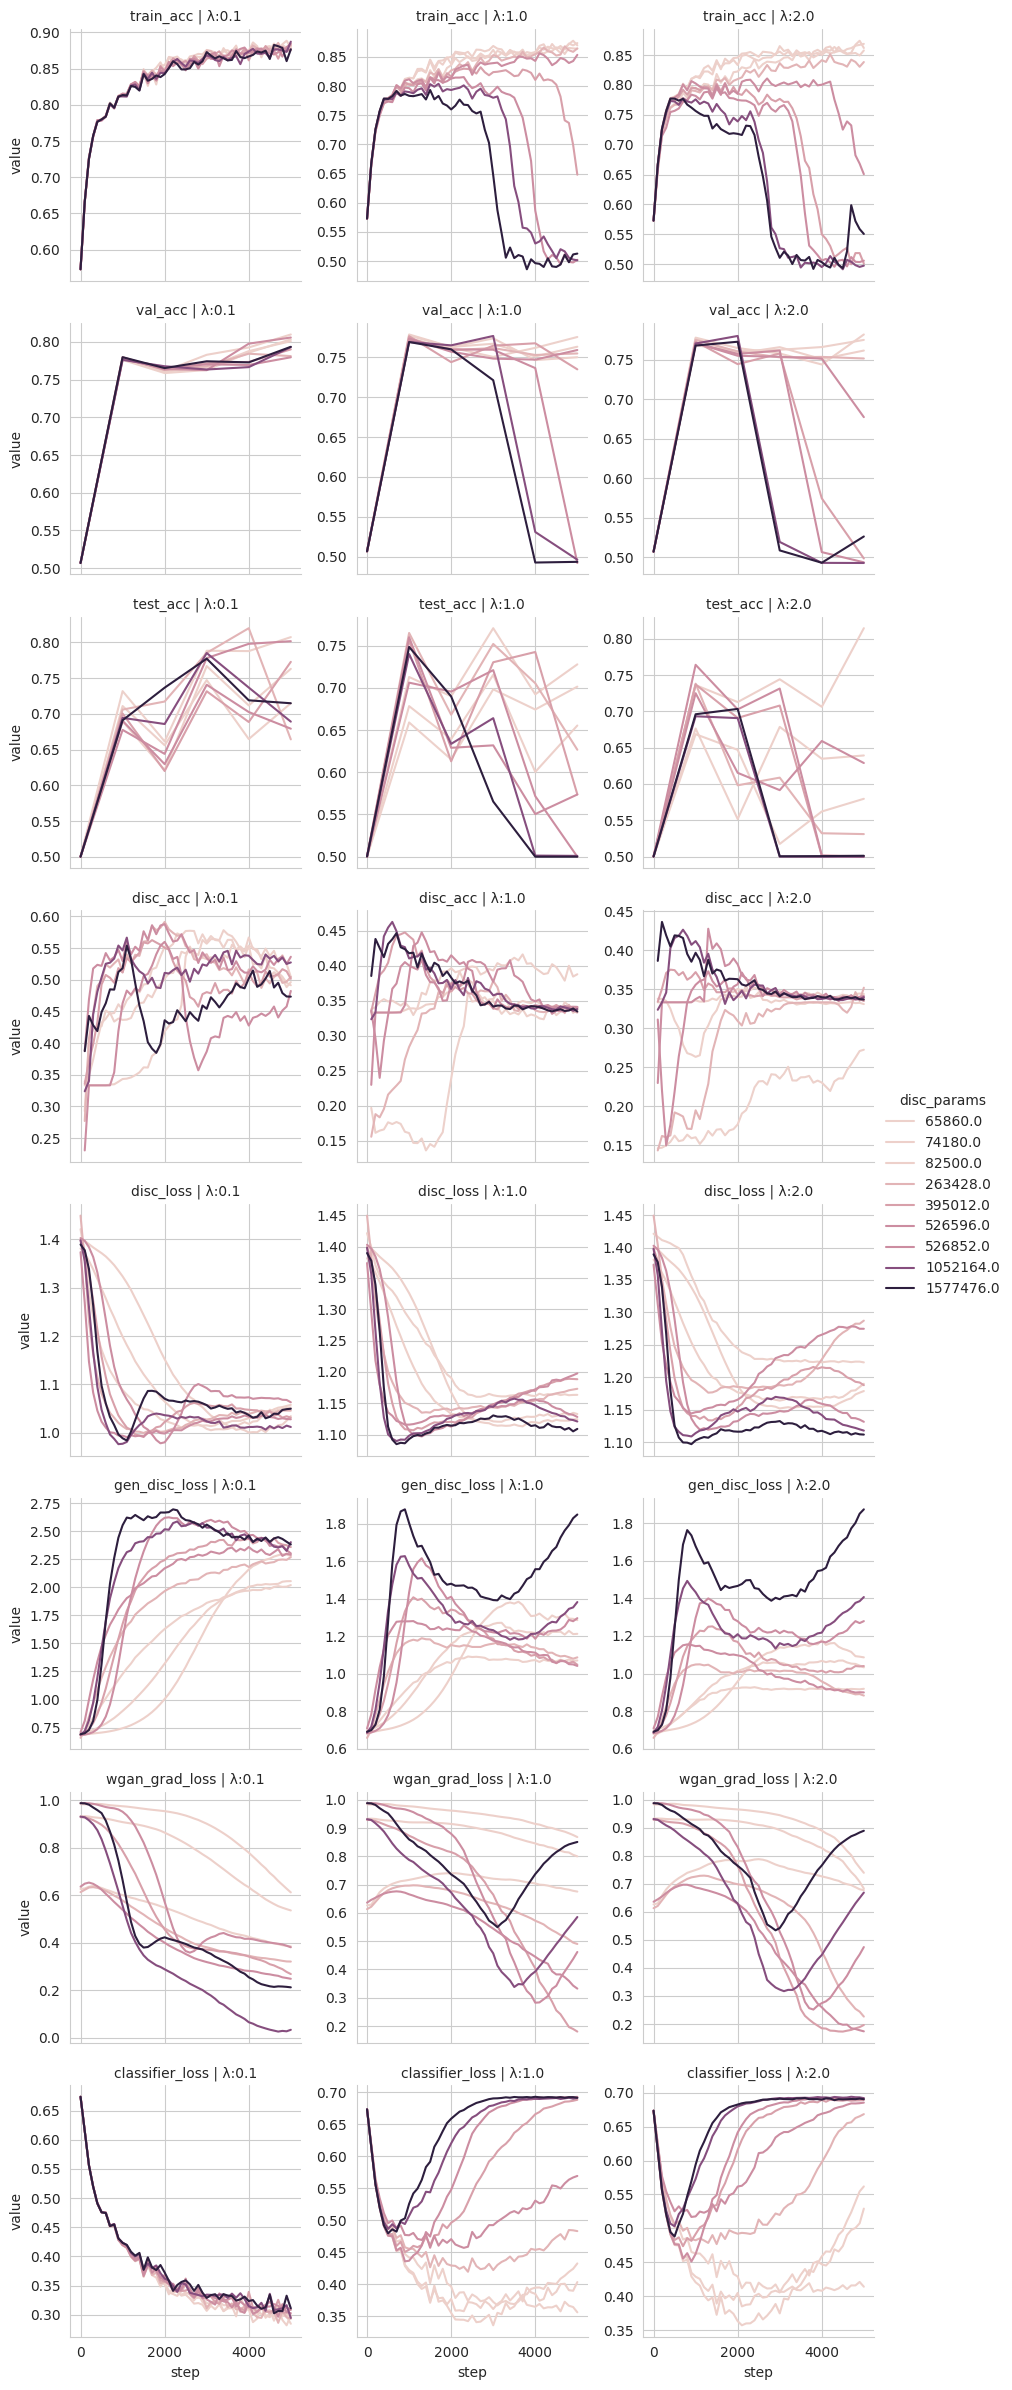

In [81]:
plot_facet_grid(arch_df.query('grad_penalty==0'), hue='disc_params', y='value', row='metric', col='dann_lambda', melt_metrics=base_metrics, palette=None)

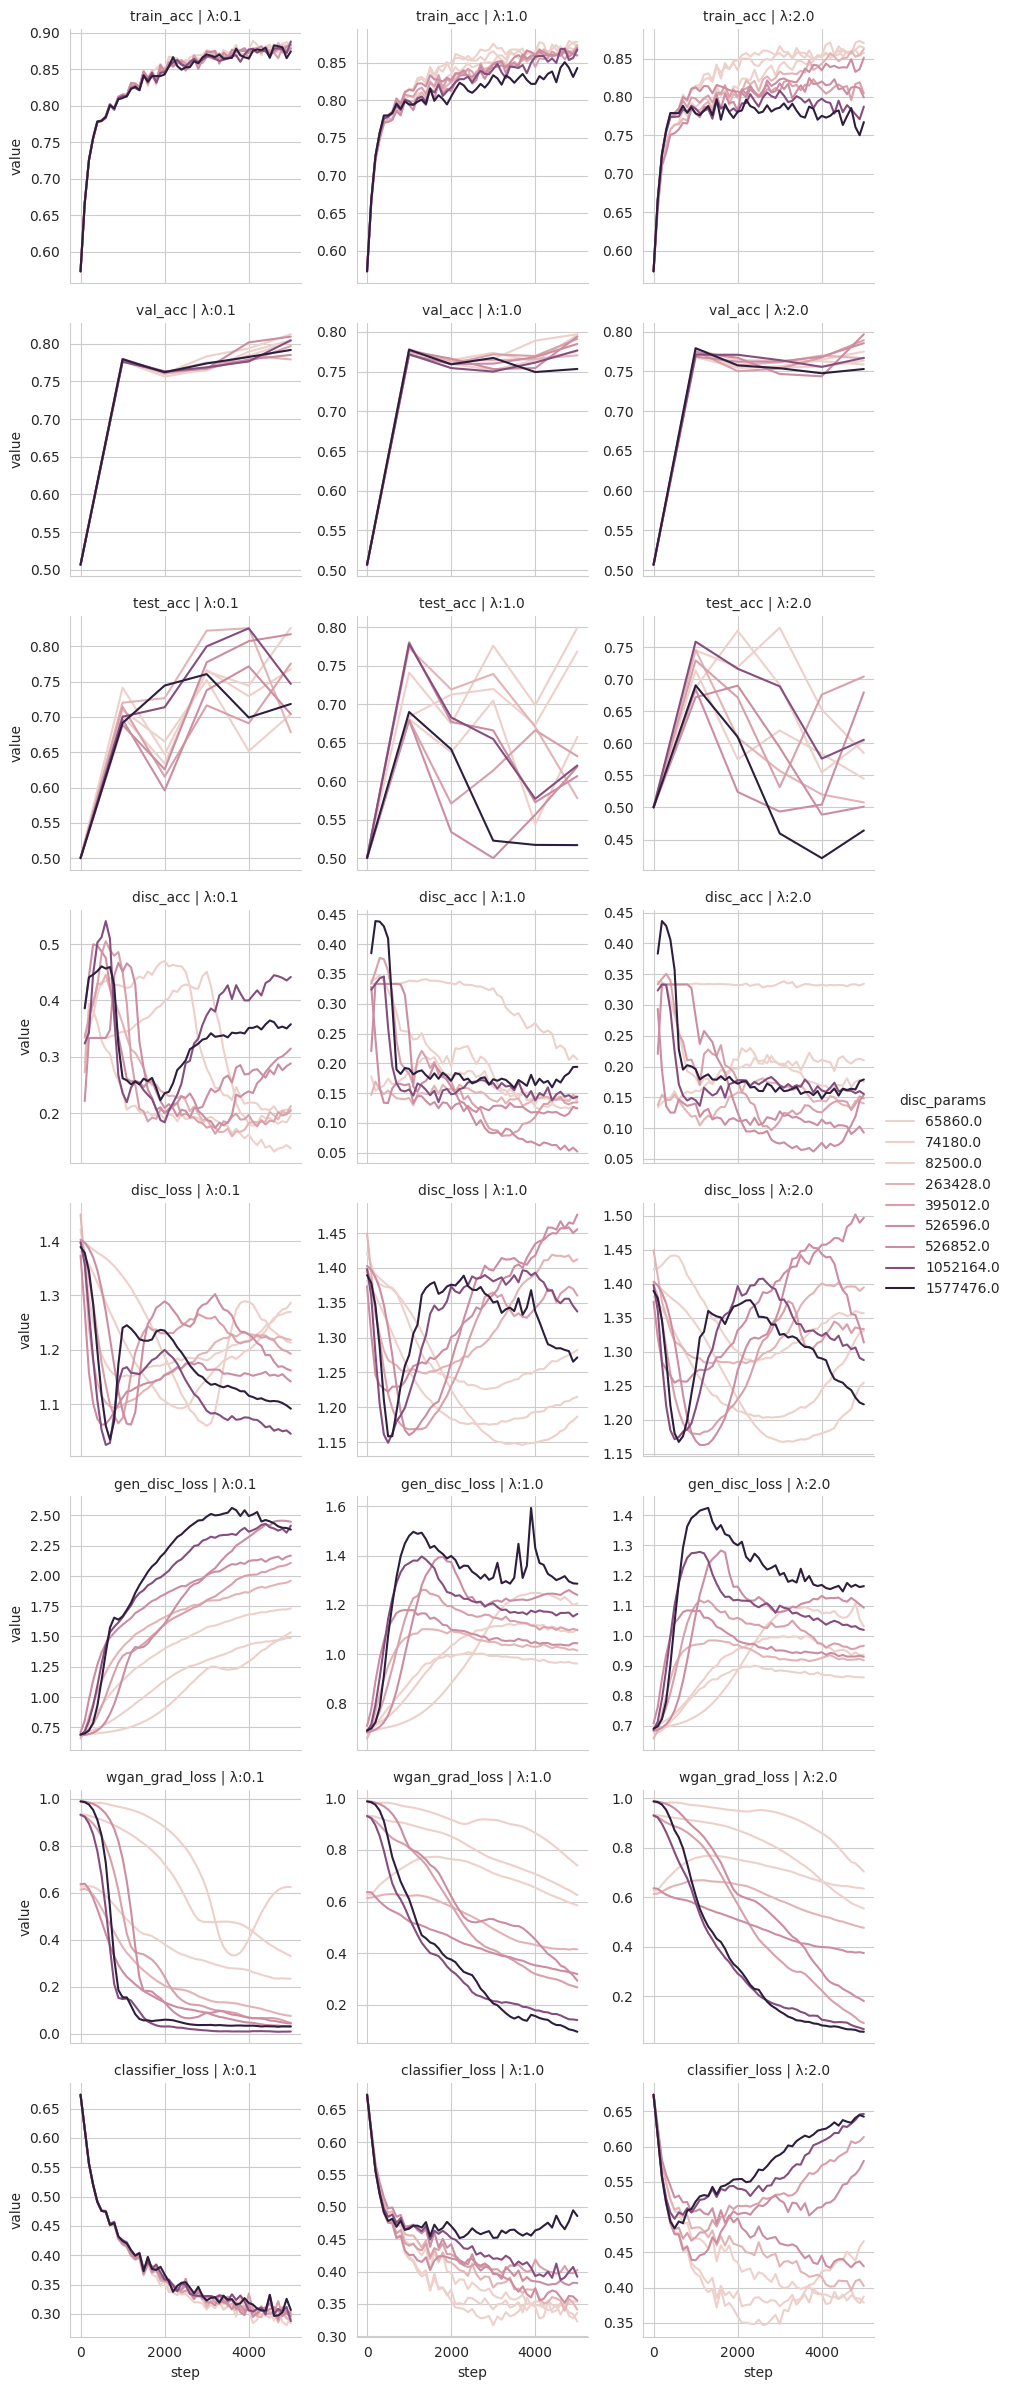

In [82]:
plot_facet_grid(arch_df.query('grad_penalty==1'), hue='disc_params', y='value', row='metric', col='dann_lambda', melt_metrics=base_metrics, palette=None)        